# Setup

In [2]:
%matplotlib inline
# from theano import tensor as tt
# from theano import shared as th_shared
# import theano
# import pymc3 as pm
# import arviz as az
# import xarray as xr
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
from IPython.core.pylabtools import figsize
from warnings import filterwarnings
filterwarnings('ignore')
sns.set_style('white')
from sklearn import datasets
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing._label import _encode
from sklearn.utils import column_or_1d
import yaml
from datetime import datetime, timedelta
import random
import math
import os
import sys
import importlib
import inspect
from scipy.stats import norm

In [3]:
os.chdir(os.path.expanduser('~/my_projects/bayesian_inference/probabilistic_evaluation/'))
os.getcwd()

'/Users/sahilmaheshwari/my_projects/bayesian_inference/probabilistic_evaluation'

In [4]:
from src.utils import get_weigAv_prob_rank, get_weigAv_hdi_rank, get_error_sd_metric, get_z_metric

In [5]:
# importlib.reload()

In [6]:
# inspect.getsource(get_weigAv_prob_rank)

"def get_weigAv_prob_rank(df_pred, target='onrent', n_bins=20):\n    df_pred = get_bins(df_pred, target, n_bins)\n    df_pred = get_prob_mass(df_pred, target)\n    df_pred = get_pred_dist(df_pred, target)\n    \n    # get metric from probs data\n    prob_col_names = df_pred.filter(regex=target + '_bin_[0-9]+_prob').columns\n    sum_probsOverObs = df_pred[prob_col_names].sum(axis=0)\n    prob_mass_in_ranges = sum_probsOverObs/df_pred.shape[0]\n    # print(prob_mass_in_ranges)\n    print('prob. mass covered: ', prob_mass_in_ranges.sum())\n    weigAv_prob_rank = (prob_mass_in_ranges * (np.arange(len(prob_mass_in_ranges))+1)).sum()\n    return df_pred, prob_mass_in_ranges, weigAv_prob_rank\n"

# Simulating data

## Trend

In [5]:
def get_trend(t, a, b):
    return a + b*t

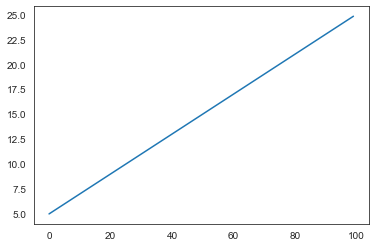

In [6]:
t = np.arange(100)
plt.plot(t, get_trend(t, 5, 0.2))

## Seasonality

In [7]:
def get_fourier_terms(t, p, n):
    x = 2 * np.pi * (np.arange(n) + 1) * t[:, None] / p
    return np.concatenate((np.cos(x), np.sin(x)), axis=1)

'n' decides pairs of sin and cos to generate. 'p' decides the period of wave.  
In output, rows is same as t, cols is n*2 with first all cos and then all sins

In [8]:
def get_seasonality(t, p, n, coef):
    fourier_terms = get_fourier_terms(t, p, n)
    return np.sum(fourier_terms * coef, axis=1)

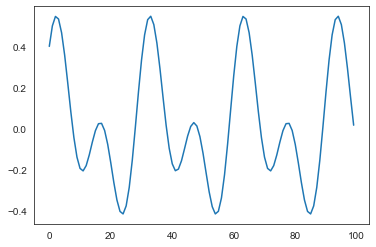

In [9]:
plt.plot(t, get_seasonality(t, 30.5, 2, 0.2))

## Overall - Additive

In [10]:
n_points = 730
t = np.arange(n_points)

trend_intercept = 5
trend_coef = 0.1
trend = get_trend(t, trend_intercept, trend_coef)

weekly_seas_coef = 1.2
weekly_seas = get_seasonality(t, 7, 3, weekly_seas_coef)

monthly_seas_coef = 1.5
monthly_seas = get_seasonality(t, 30.5, 5, monthly_seas_coef)

yearly_seas_coef = 4
yearly_seas = get_seasonality(t, 365.5, 7, yearly_seas_coef)

mu = (trend + weekly_seas + monthly_seas + yearly_seas).round(0).astype(int)

noise_mean = 2
noise_sigma = 5
noise = np.random.normal(noise_mean, noise_sigma, n_points).round(0).astype(int)

y = mu + noise

print(pd.DataFrame({'mu': mu, 'noise': noise, 'y': y}))

     mu  noise    y
0    44      0   44
1    47      3   50
2    44      3   47
3    42     -3   39
4    38      3   41
..   ..    ...  ...
725  90     -2   88
726  94      2   96
727  92      9  101
728  98      1   99
729  98     -1   97

[730 rows x 3 columns]


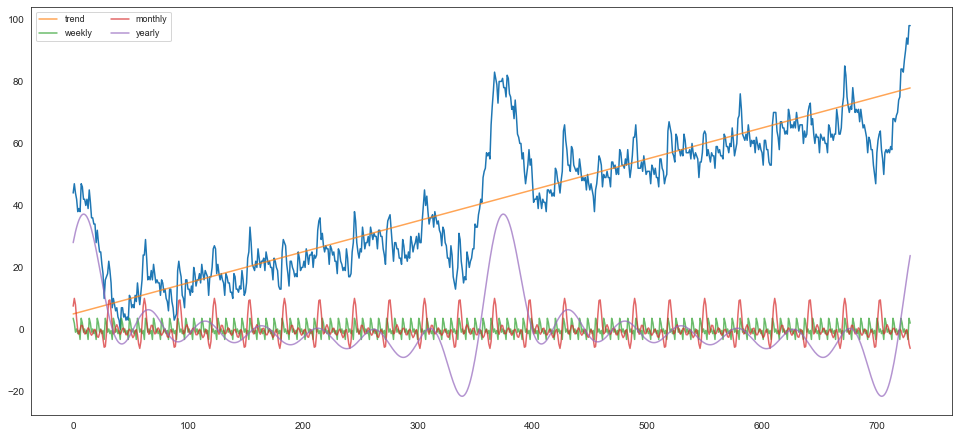

In [11]:
_, ax = plt.subplots(figsize=(16.5, 7.5))
ax.plot(t, mu)
# ax.plot(t, y, alpha=0.7)
ax.plot(t, trend, alpha=0.7, label="trend")
ax.plot(t, weekly_seas, alpha=0.7, label='weekly')
ax.plot(t, monthly_seas, alpha=0.7, label='monthly')
ax.plot(t, yearly_seas, alpha=0.7, label="yearly")
# ax.plot(t, trend+yearly_seas, alpha=0.7, label="trend+yearly")
ax.legend(ncol=2, fontsize=9, frameon=True);
plt.show()

# Simulating forecast

## Functions

In [12]:
def get_forecast_samples(mean, sd, sample_size=1000, seed=123):
    forecast_dists = map(norm, mean, sd)
    np.random.seed(seed)
    return np.array([dist.rvs(size=sample_size) for dist in list(forecast_dists)])

def get_forcast_range(forecast_samples):
    forecast_mean = forecast_samples.mean(axis=1)
    forecast_low = np.quantile(forecast_samples, 0.025, axis=1)
    forecast_high = np.quantile(forecast_samples, 0.975, axis=1)
    return np.column_stack((forecast_low, forecast_mean, forecast_high))

def plot_forecast(actual, pred):
    _, ax = plt.subplots(figsize=(16.5, 7.5))
    ax.plot(actual)
    ax.plot(pred[:,0], alpha=0.7)
    ax.plot(pred[:,1], alpha=0.7)
    ax.plot(pred[:,2], alpha=0.7)
    plt.show()

## Mean, variance for high coverage

In [13]:
from scipy.stats import norm
forecast_1_dist_mean = np.mean(mu).round(0).astype(int)
print(forecast_1_dist_mean)
forecast_1_dist_sd = ((np.quantile(mu, 0.99) - np.quantile(mu, 0.01))/3).round(0).astype(int)
print(forecast_1_dist_sd)
forecast_1_dist = norm(forecast_1_dist_mean, forecast_1_dist_sd)

41
27


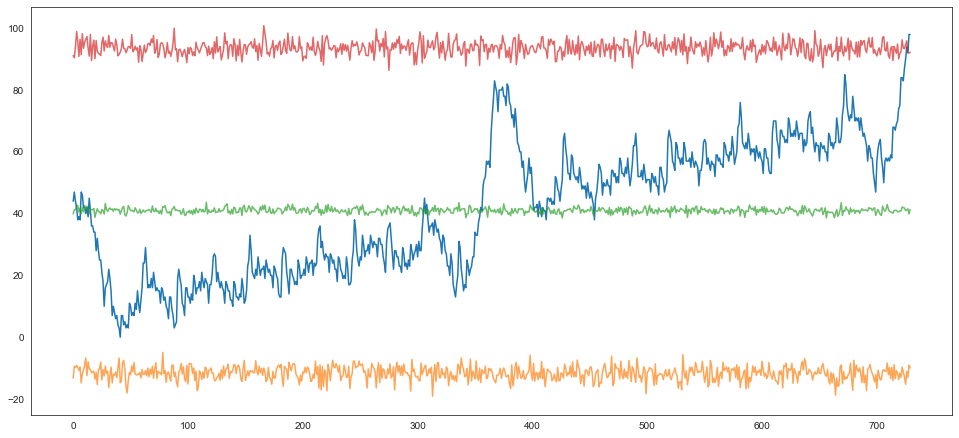

In [14]:
forecast_1_samples = get_forecast_samples(np.repeat(forecast_1_dist_mean, t.size), np.repeat(forecast_1_dist_sd, t.size))
forecast_1_pred = get_forcast_range(forecast_1_samples)
plot_forecast(mu, forecast_1_pred)

In [15]:
train_pred = pd.DataFrame({'t': t, 'onrent': mu, 'onrent_pred_mean': forecast_1_dist_mean, 'onrent_pred_stddev': forecast_1_dist_sd})

df_pred, prob_mass_in_ranges, weigAv_prob_rank = get_weigAv_prob_rank(train_pred.copy(deep=True))
print(weigAv_prob_rank)

prob. mass covered:  0.9831206413642041
6.9981252541821215


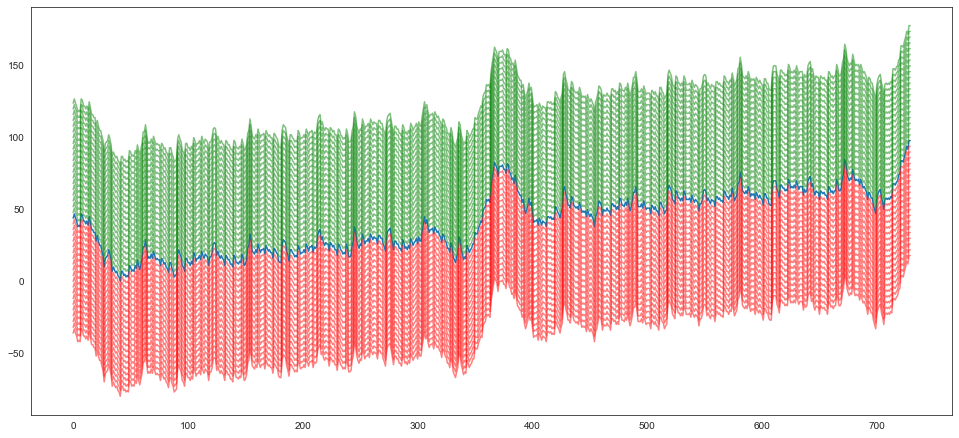

In [16]:
col_regex = 'onrent_bin_[0-9]+$'
bin_cols = df_pred.filter(regex=col_regex).columns

df = pd.DataFrame()
for col_name in bin_cols:
    df[[col_name + '_low', col_name + '_high']] = pd.DataFrame(df_pred[col_name].tolist(), index= df_pred.index)

_, ax = plt.subplots(figsize=(16.5, 7.5))
ax.plot(t, mu)

for col in df.columns:
    if 'low' in col:
        color='red'
    else:
        color='green'
    ax.plot(t, df[col], alpha=0.5, c=color)

plt.show()

## Mean, variance for low coverage

In [137]:
from scipy.stats import norm
forecast_1_dist_mean = np.mean(mu).round(0).astype(int)
print(forecast_1_dist_mean)
forecast_1_dist_sd = ((np.quantile(mu, 0.75) - np.quantile(mu, 0.25))/3).round(0).astype(int)
print(forecast_1_dist_sd)
forecast_1_dist = norm(forecast_1_dist_mean, forecast_1_dist_sd)

41
12


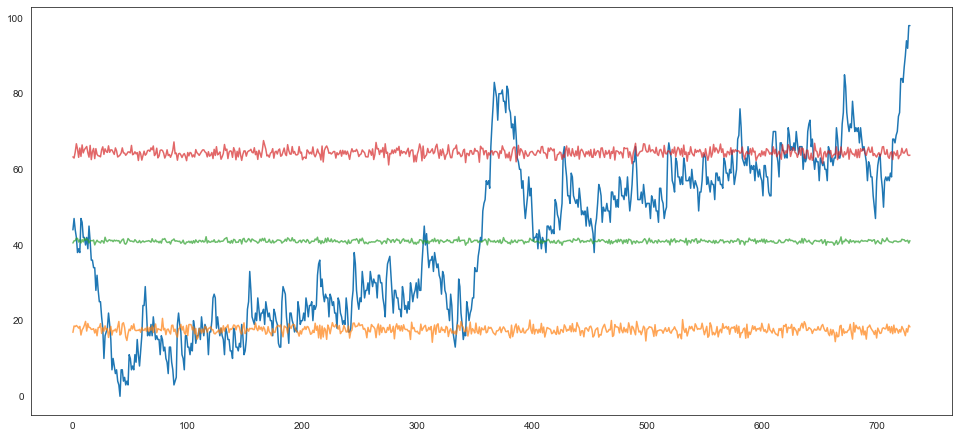

In [138]:
forecast_1_samples = get_forecast_samples(np.repeat(forecast_1_dist_mean, t.size), np.repeat(forecast_1_dist_sd, t.size))
forecast_1_pred = get_forcast_range(forecast_1_samples)
plot_forecast(mu, forecast_1_pred)

In [139]:
train_pred = pd.DataFrame({'t': t, 'onrent': mu, 'onrent_pred_mean': forecast_1_dist_mean, 'onrent_pred_stddev': forecast_1_dist_sd})

df_pred, prob_mass_in_ranges, weigAv_prob_rank = get_weigAv_prob_rank(train_pred.copy(deep=True))
print(weigAv_prob_rank)

onrent_bin_01_prob    0.05
onrent_bin_02_prob    0.05
onrent_bin_03_prob    0.05
onrent_bin_04_prob    0.05
onrent_bin_05_prob    0.05
onrent_bin_06_prob    0.05
onrent_bin_07_prob    0.06
onrent_bin_08_prob    0.06
onrent_bin_09_prob    0.06
onrent_bin_10_prob    0.05
onrent_bin_11_prob    0.05
onrent_bin_12_prob    0.05
onrent_bin_13_prob    0.05
onrent_bin_14_prob    0.04
onrent_bin_15_prob    0.04
onrent_bin_16_prob    0.04
onrent_bin_17_prob    0.03
onrent_bin_18_prob    0.03
onrent_bin_19_prob    0.02
onrent_bin_20_prob    0.02
dtype: float64
prob. mass covered:  0.9162354496690959
8.58608546211441


## Trend, variance for high coverage

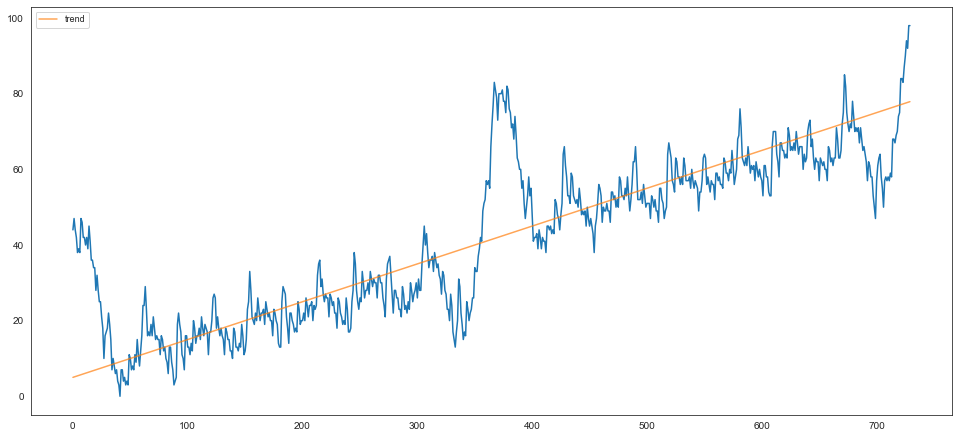

In [147]:
_, ax = plt.subplots(figsize=(16.5, 7.5))
ax.plot(t, mu)
ax.plot(t, trend, alpha=0.7, label="trend")
ax.legend(ncol=2, fontsize=9, frameon=True);
plt.show()

In [150]:
from scipy.stats import norm
forecast_1_dist_mean = trend
# print(forecast_1_dist_mean)
forecast_1_dist_sd = ((np.quantile(mu, 0.99) - np.quantile(mu, 0.01))/3).round(0).astype(int)
# print(forecast_1_dist_sd)
forecast_1_dist = norm(forecast_1_dist_mean, forecast_1_dist_sd)

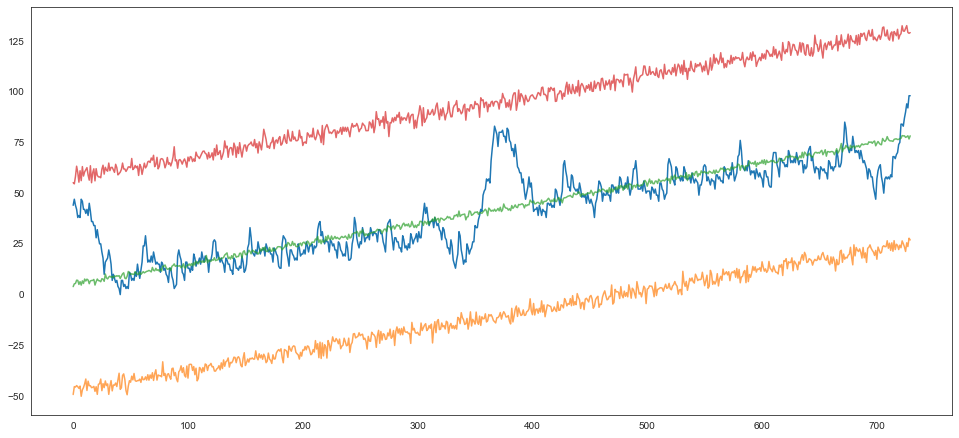

In [151]:
forecast_1_samples = get_forecast_samples(forecast_1_dist_mean, np.repeat(forecast_1_dist_sd, t.size))
forecast_1_pred = get_forcast_range(forecast_1_samples)
plot_forecast(mu, forecast_1_pred)

In [152]:
train_pred = pd.DataFrame({'t': t, 'onrent': mu, 'onrent_pred_mean': forecast_1_dist_mean, 'onrent_pred_stddev': forecast_1_dist_sd})

df_pred, prob_mass_in_ranges, weigAv_prob_rank = get_weigAv_prob_rank(train_pred.copy(deep=True))
print(weigAv_prob_rank)

onrent_bin_01_prob    1.10e-01
onrent_bin_02_prob    1.08e-01
onrent_bin_03_prob    1.04e-01
onrent_bin_04_prob    9.78e-02
onrent_bin_05_prob    9.05e-02
onrent_bin_06_prob    8.22e-02
onrent_bin_07_prob    7.32e-02
onrent_bin_08_prob    6.40e-02
onrent_bin_09_prob    5.50e-02
onrent_bin_10_prob    4.63e-02
onrent_bin_11_prob    3.83e-02
onrent_bin_12_prob    3.11e-02
onrent_bin_13_prob    2.49e-02
onrent_bin_14_prob    1.95e-02
onrent_bin_15_prob    1.51e-02
onrent_bin_16_prob    1.14e-02
onrent_bin_17_prob    8.55e-03
onrent_bin_18_prob    6.29e-03
onrent_bin_19_prob    4.55e-03
onrent_bin_20_prob    3.25e-03
dtype: float64
prob. mass covered:  0.9930198546034938
6.166297418297718


## Yearly seasonality, variance for high coverage

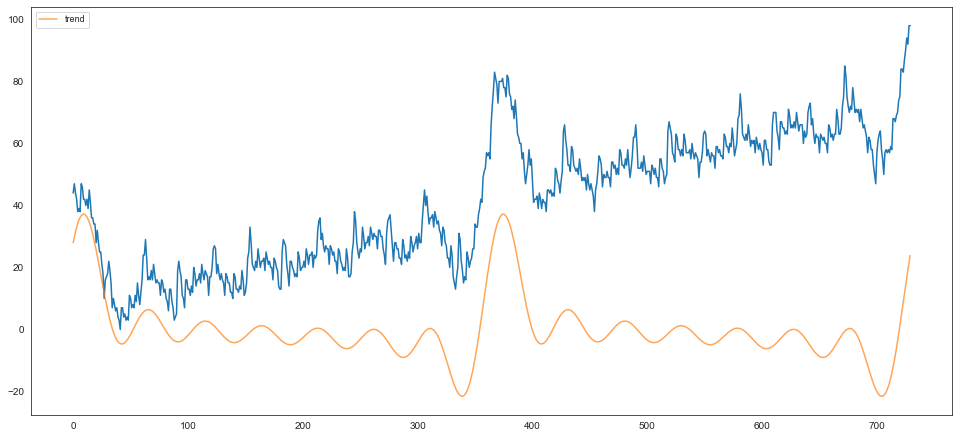

In [153]:
_, ax = plt.subplots(figsize=(16.5, 7.5))
ax.plot(t, mu)
ax.plot(t, yearly_seas, alpha=0.7, label="trend")
ax.legend(ncol=2, fontsize=9, frameon=True);
plt.show()

In [154]:
from scipy.stats import norm
forecast_1_dist_mean = yearly_seas
# print(forecast_1_dist_mean)
forecast_1_dist_sd = ((np.quantile(mu, 0.99) - np.quantile(mu, 0.01))/3).round(0).astype(int)
# print(forecast_1_dist_sd)
forecast_1_dist = norm(forecast_1_dist_mean, forecast_1_dist_sd)

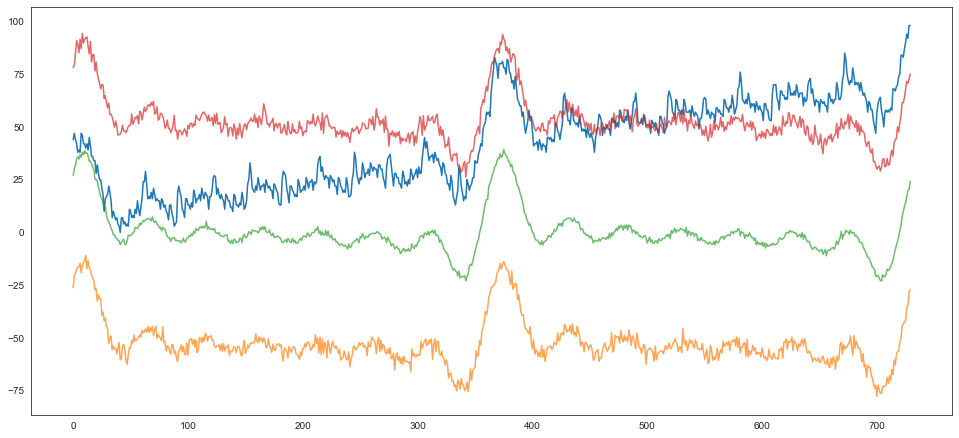

In [155]:
forecast_1_samples = get_forecast_samples(forecast_1_dist_mean, np.repeat(forecast_1_dist_sd, t.size))
forecast_1_pred = get_forcast_range(forecast_1_samples)
plot_forecast(mu, forecast_1_pred)

In [156]:
train_pred = pd.DataFrame({'t': t, 'onrent': mu, 'onrent_pred_mean': forecast_1_dist_mean, 'onrent_pred_stddev': forecast_1_dist_sd})

df_pred, prob_mass_in_ranges, weigAv_prob_rank = get_weigAv_prob_rank(train_pred.copy(deep=True))
print(weigAv_prob_rank)

onrent_bin_01_prob    0.05
onrent_bin_02_prob    0.05
onrent_bin_03_prob    0.05
onrent_bin_04_prob    0.05
onrent_bin_05_prob    0.05
onrent_bin_06_prob    0.05
onrent_bin_07_prob    0.05
onrent_bin_08_prob    0.05
onrent_bin_09_prob    0.05
onrent_bin_10_prob    0.05
onrent_bin_11_prob    0.05
onrent_bin_12_prob    0.05
onrent_bin_13_prob    0.04
onrent_bin_14_prob    0.04
onrent_bin_15_prob    0.04
onrent_bin_16_prob    0.04
onrent_bin_17_prob    0.04
onrent_bin_18_prob    0.03
onrent_bin_19_prob    0.03
onrent_bin_20_prob    0.03
dtype: float64
prob. mass covered:  0.8649667543410319
8.477418757787477


## Yearly seasonality adjusted, variance for high coverage

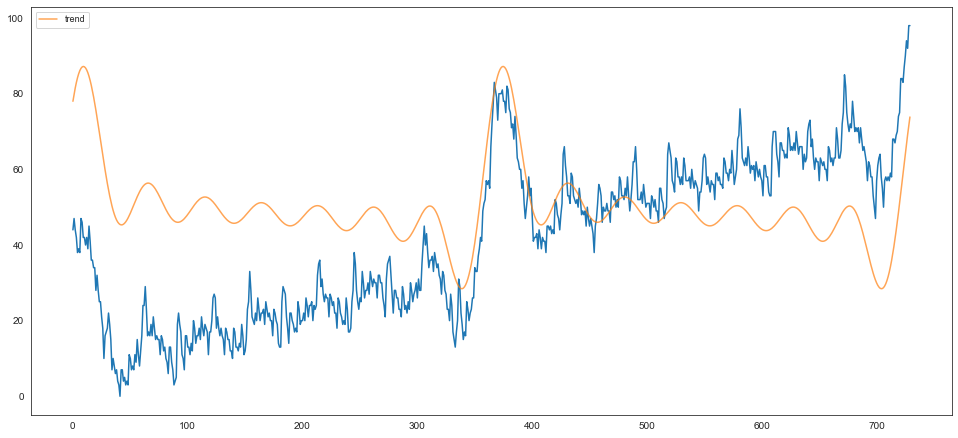

In [18]:
_, ax = plt.subplots(figsize=(16.5, 7.5))
ax.plot(t, mu)
ax.plot(t, yearly_seas+50, alpha=0.7, label="trend")
ax.legend(ncol=2, fontsize=9, frameon=True);
plt.show()

In [32]:
from scipy.stats import norm
forecast_1_dist_mean = yearly_seas+40
# print(forecast_1_dist_mean)
forecast_1_dist_sd = ((np.quantile(mu, 0.99) - np.quantile(mu, 0.01))/3).round(0).astype(int)
# print(forecast_1_dist_sd)
forecast_1_dist = norm(forecast_1_dist_mean, forecast_1_dist_sd)

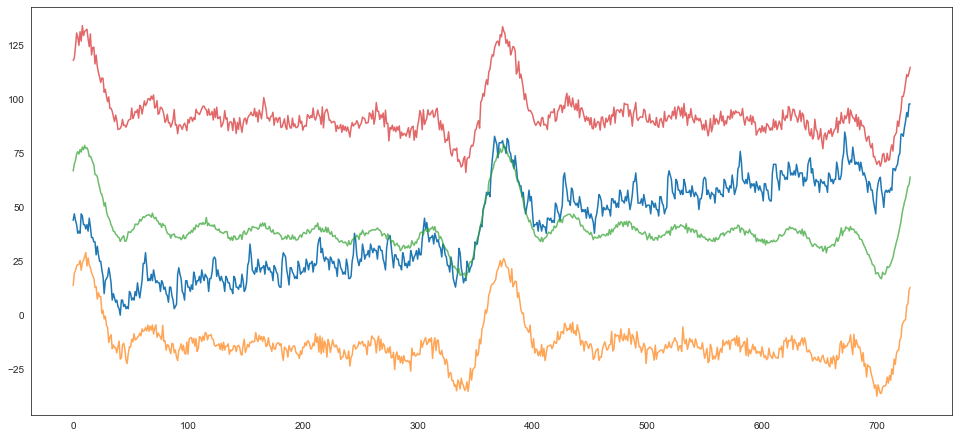

In [33]:
forecast_1_samples = get_forecast_samples(forecast_1_dist_mean, np.repeat(forecast_1_dist_sd, t.size))
forecast_1_pred = get_forcast_range(forecast_1_samples)
plot_forecast(mu, forecast_1_pred)

In [34]:
train_pred = pd.DataFrame({'t': t, 'onrent': mu, 'onrent_pred_mean': forecast_1_dist_mean, 'onrent_pred_stddev': forecast_1_dist_sd})

df_pred, prob_mass_in_ranges, weigAv_prob_rank = get_weigAv_prob_rank(train_pred.copy(deep=True))
print(weigAv_prob_rank)

prob. mass covered:  0.9824654369931705
7.035184211163531


## Yearly seasonality adjusted, variance for low coverage

In [35]:
from scipy.stats import norm
forecast_1_dist_mean = yearly_seas+40
# print(forecast_1_dist_mean)
forecast_1_dist_sd = ((np.quantile(mu, 0.75) - np.quantile(mu, 0.25))/3).round(0).astype(int)
# print(forecast_1_dist_sd)
forecast_1_dist = norm(forecast_1_dist_mean, forecast_1_dist_sd)

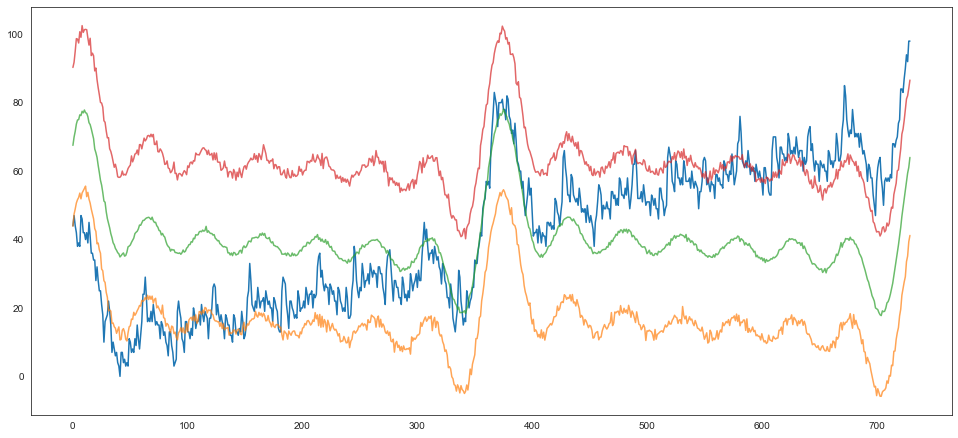

In [36]:
forecast_1_samples = get_forecast_samples(forecast_1_dist_mean, np.repeat(forecast_1_dist_sd, t.size))
forecast_1_pred = get_forcast_range(forecast_1_samples)
plot_forecast(mu, forecast_1_pred)

In [156]:
train_pred = pd.DataFrame({'t': t, 'onrent': mu, 'onrent_pred_mean': forecast_1_dist_mean, 'onrent_pred_stddev': forecast_1_dist_sd})

df_pred, prob_mass_in_ranges, weigAv_prob_rank = get_weigAv_prob_rank(train_pred.copy(deep=True))
print(weigAv_prob_rank)

onrent_bin_01_prob    0.05
onrent_bin_02_prob    0.05
onrent_bin_03_prob    0.05
onrent_bin_04_prob    0.05
onrent_bin_05_prob    0.05
onrent_bin_06_prob    0.05
onrent_bin_07_prob    0.05
onrent_bin_08_prob    0.05
onrent_bin_09_prob    0.05
onrent_bin_10_prob    0.05
onrent_bin_11_prob    0.05
onrent_bin_12_prob    0.05
onrent_bin_13_prob    0.04
onrent_bin_14_prob    0.04
onrent_bin_15_prob    0.04
onrent_bin_16_prob    0.04
onrent_bin_17_prob    0.04
onrent_bin_18_prob    0.03
onrent_bin_19_prob    0.03
onrent_bin_20_prob    0.03
dtype: float64
prob. mass covered:  0.8649667543410319
8.477418757787477


## Trend + Yearly seasonality, variance for high coverage

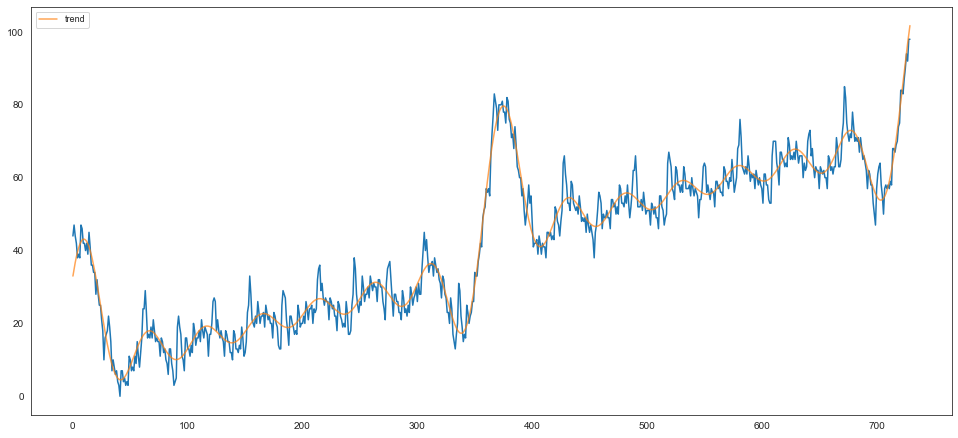

In [157]:
_, ax = plt.subplots(figsize=(16.5, 7.5))
ax.plot(t, mu)
ax.plot(t, trend+yearly_seas, alpha=0.7, label="trend")
ax.legend(ncol=2, fontsize=9, frameon=True);
plt.show()

In [158]:
from scipy.stats import norm
forecast_1_dist_mean = trend + yearly_seas
# print(forecast_1_dist_mean)
forecast_1_dist_sd = ((np.quantile(mu, 0.99) - np.quantile(mu, 0.01))/3).round(0).astype(int)
# print(forecast_1_dist_sd)
forecast_1_dist = norm(forecast_1_dist_mean, forecast_1_dist_sd)

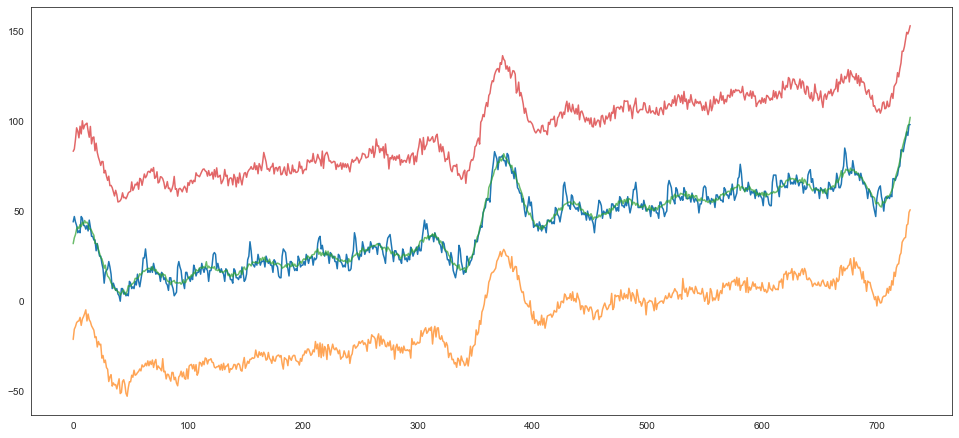

In [159]:
forecast_1_samples = get_forecast_samples(forecast_1_dist_mean, np.repeat(forecast_1_dist_sd, t.size))
forecast_1_pred = get_forcast_range(forecast_1_samples)
plot_forecast(mu, forecast_1_pred)

In [160]:
train_pred = pd.DataFrame({'t': t, 'onrent': mu, 'onrent_pred_mean': forecast_1_dist_mean, 'onrent_pred_stddev': forecast_1_dist_sd})

df_pred, prob_mass_in_ranges, weigAv_prob_rank = get_weigAv_prob_rank(train_pred.copy(deep=True))
print(weigAv_prob_rank)

onrent_bin_01_prob    1.17e-01
onrent_bin_02_prob    1.14e-01
onrent_bin_03_prob    1.09e-01
onrent_bin_04_prob    1.02e-01
onrent_bin_05_prob    9.40e-02
onrent_bin_06_prob    8.45e-02
onrent_bin_07_prob    7.43e-02
onrent_bin_08_prob    6.39e-02
onrent_bin_09_prob    5.38e-02
onrent_bin_10_prob    4.44e-02
onrent_bin_11_prob    3.58e-02
onrent_bin_12_prob    2.83e-02
onrent_bin_13_prob    2.19e-02
onrent_bin_14_prob    1.65e-02
onrent_bin_15_prob    1.23e-02
onrent_bin_16_prob    8.88e-03
onrent_bin_17_prob    6.30e-03
onrent_bin_18_prob    4.38e-03
onrent_bin_19_prob    2.98e-03
onrent_bin_20_prob    1.98e-03
dtype: float64
prob. mass covered:  0.9966268136459709
5.876640738580155


## Trend + Yearly seasonality, variance for low coverage

In [161]:
from scipy.stats import norm
forecast_1_dist_mean = trend + yearly_seas
# print(forecast_1_dist_mean)
forecast_1_dist_sd = ((np.quantile(mu, 0.75) - np.quantile(mu, 0.25))/3).round(0).astype(int)
# print(forecast_1_dist_sd)
forecast_1_dist = norm(forecast_1_dist_mean, forecast_1_dist_sd)

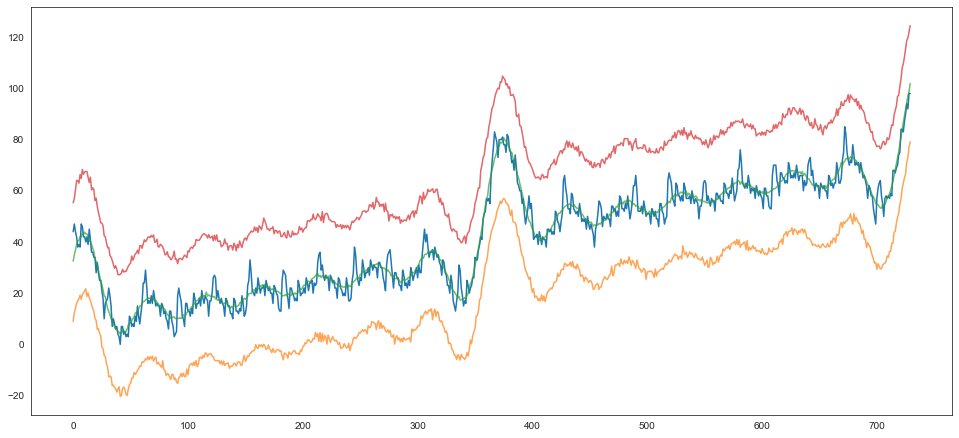

In [162]:
forecast_1_samples = get_forecast_samples(forecast_1_dist_mean, np.repeat(forecast_1_dist_sd, t.size))
forecast_1_pred = get_forcast_range(forecast_1_samples)
plot_forecast(mu, forecast_1_pred)

In [167]:
train_pred = pd.DataFrame({'t': t, 'onrent': mu, 'onrent_pred_mean': forecast_1_dist_mean, 'onrent_pred_stddev': forecast_1_dist_sd})

df_pred, prob_mass_in_ranges, weigAv_prob_rank = get_weigAv_prob_rank(train_pred.copy(deep=True))
print(weigAv_prob_rank)

onrent_bin_01_prob    1.26e-01
onrent_bin_02_prob    1.23e-01
onrent_bin_03_prob    1.17e-01
onrent_bin_04_prob    1.08e-01
onrent_bin_05_prob    9.80e-02
onrent_bin_06_prob    8.64e-02
onrent_bin_07_prob    7.43e-02
onrent_bin_08_prob    6.23e-02
onrent_bin_09_prob    5.10e-02
onrent_bin_10_prob    4.07e-02
onrent_bin_11_prob    3.17e-02
onrent_bin_12_prob    2.41e-02
onrent_bin_13_prob    1.78e-02
onrent_bin_14_prob    1.29e-02
onrent_bin_15_prob    9.10e-03
onrent_bin_16_prob    6.26e-03
onrent_bin_17_prob    4.21e-03
onrent_bin_18_prob    2.76e-03
onrent_bin_19_prob    1.76e-03
onrent_bin_20_prob    1.10e-03
dtype: float64
prob. mass covered:  0.9984085448550958
5.5122504951623394


## Together - get_weigAv_prob_rank

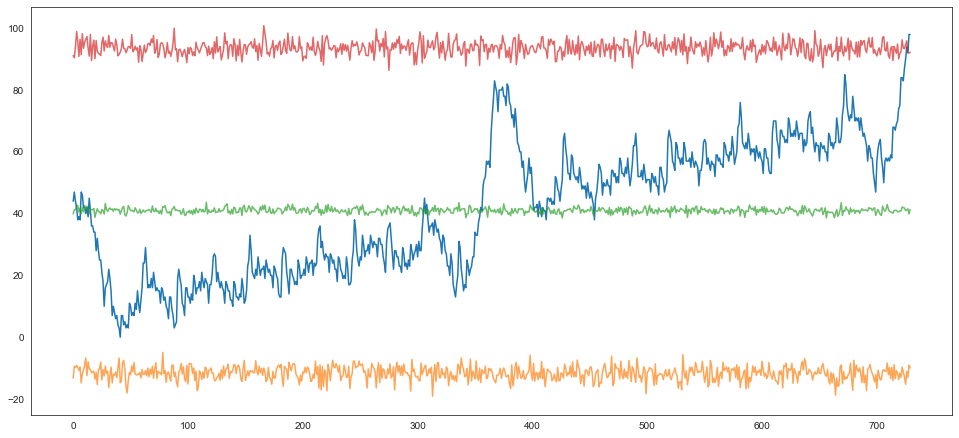

prob. mass covered:  0.9831206413642041
6.9981252541821215


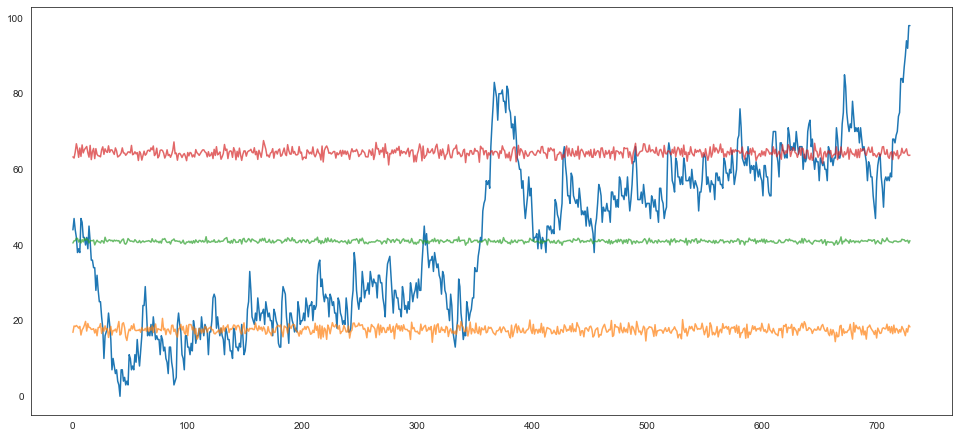

prob. mass covered:  0.9162354496690959
8.58608546211441


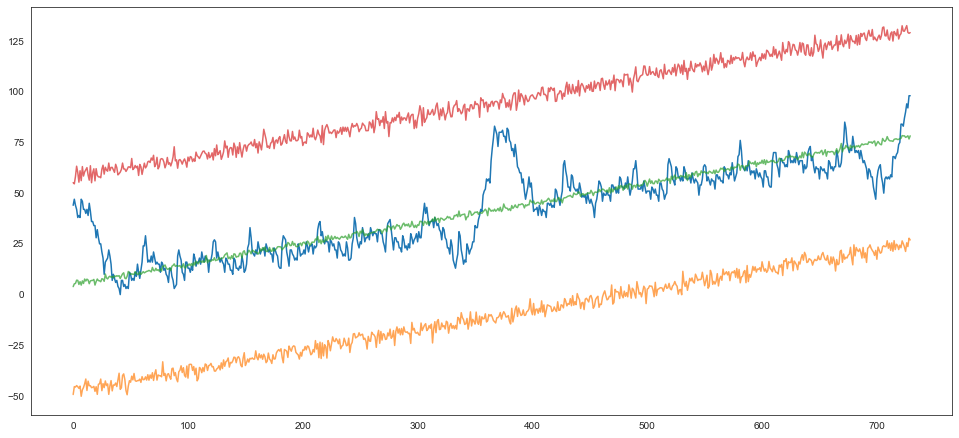

prob. mass covered:  0.9930198546034938
6.166297418297718


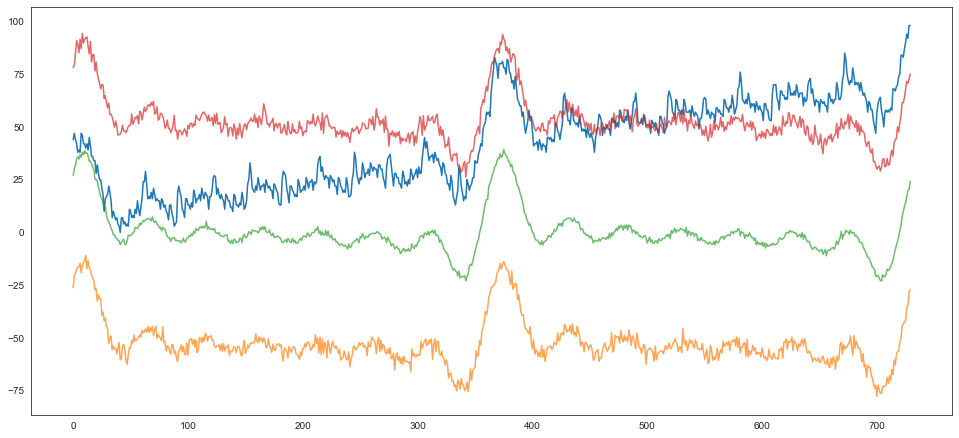

prob. mass covered:  0.8649667543410319
8.477418757787477


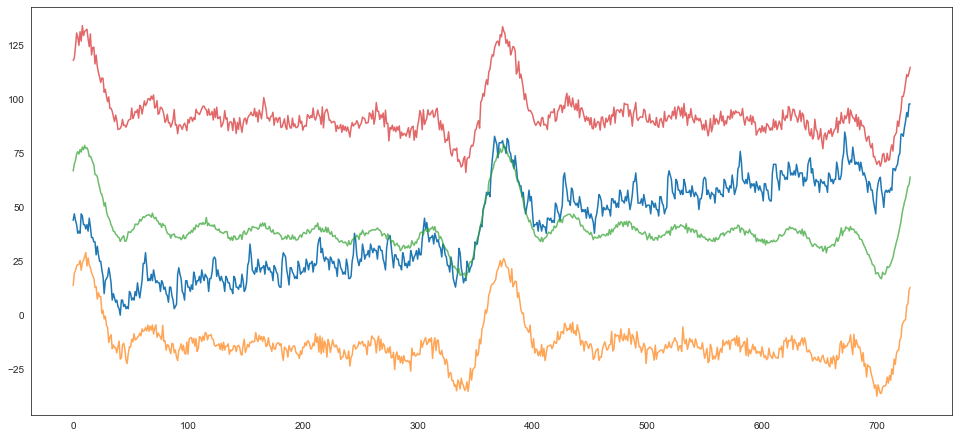

prob. mass covered:  0.9824654369931705
7.035184211163531


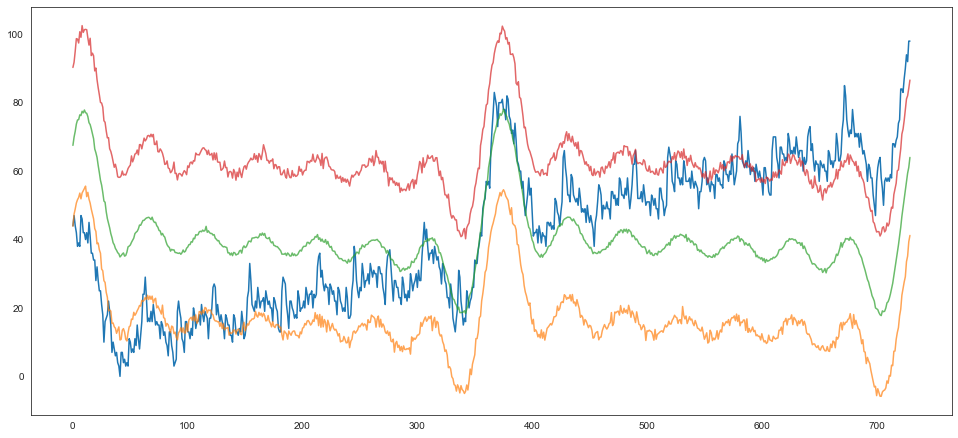

prob. mass covered:  0.9053051401920248
8.428031422761725


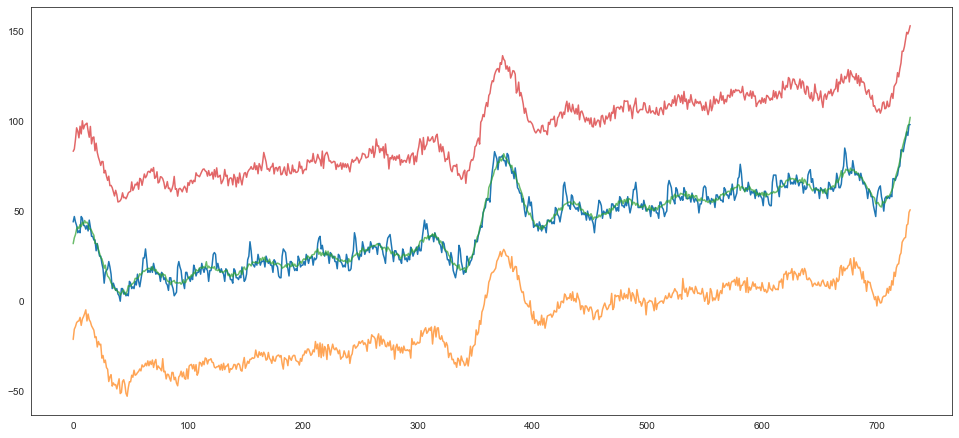

prob. mass covered:  0.9966268136459709
5.876640738580155


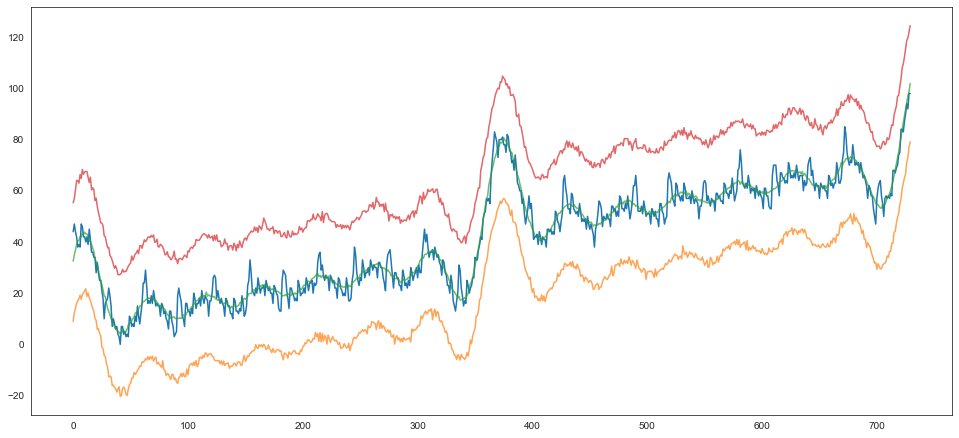

prob. mass covered:  0.9984085448550958
5.5122504951623394


In [17]:
mu_mean_repeat = np.repeat(np.mean(mu).round(0).astype(int), t.size)
forecast_means = [mu_mean_repeat, mu_mean_repeat, trend, yearly_seas, yearly_seas+40, yearly_seas+40, trend+yearly_seas, trend+yearly_seas]

forecast_sd_low_repeat = np.repeat(((np.quantile(mu, 0.75) - np.quantile(mu, 0.25))/3).round(0).astype(int), t.size)
forecast_sd_high_repeat = np.repeat(((np.quantile(mu, 0.99) - np.quantile(mu, 0.01))/3).round(0).astype(int), t.size)
forecast_sds = [forecast_sd_high_repeat, forecast_sd_low_repeat, forecast_sd_high_repeat, forecast_sd_high_repeat, forecast_sd_high_repeat, forecast_sd_low_repeat, forecast_sd_high_repeat, forecast_sd_low_repeat]

for mean, sd in zip(forecast_means, forecast_sds):
    forecast_1_samples = get_forecast_samples(mean, sd)
    pred = get_forcast_range(forecast_1_samples)

    plt.figure(figsize=(16.5, 7.5))
    plt.plot(mu)
    plt.plot(pred[:,0], alpha=0.7)
    plt.plot(pred[:,1], alpha=0.7)
    plt.plot(pred[:,2], alpha=0.7)
    plt.show()
    
    train_pred = pd.DataFrame({'t': t, 'onrent': mu, 'onrent_pred_mean': mean, 'onrent_pred_stddev': sd})
    df_pred, prob_mass_in_ranges, weigAv_prob_rank = get_weigAv_prob_rank(train_pred.copy(deep=True))
    print(weigAv_prob_rank)

## Together - get_error_sd_metric

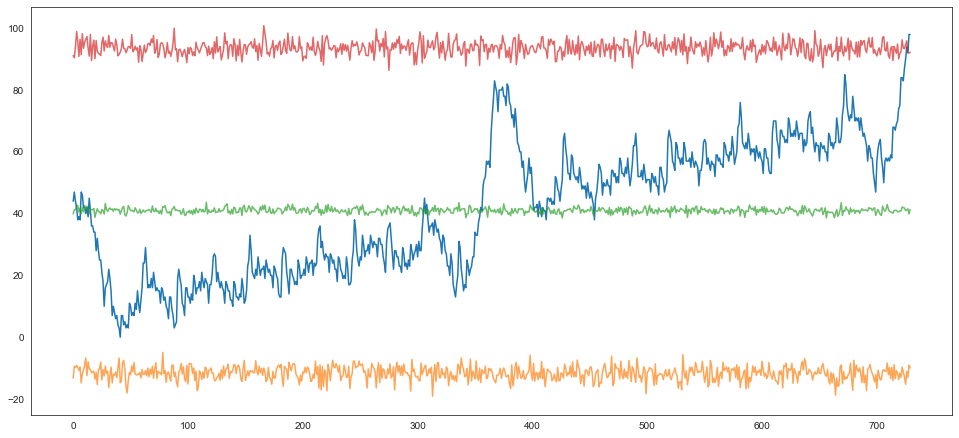

29.27123287671233


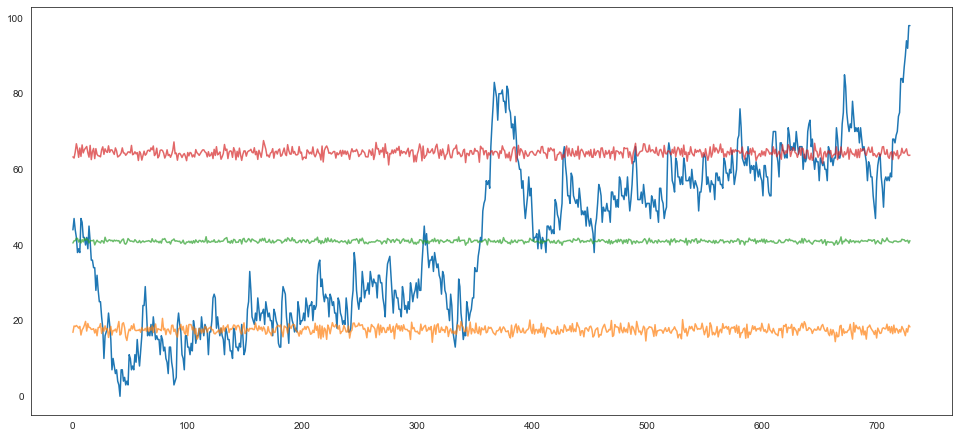

27.90958904109589


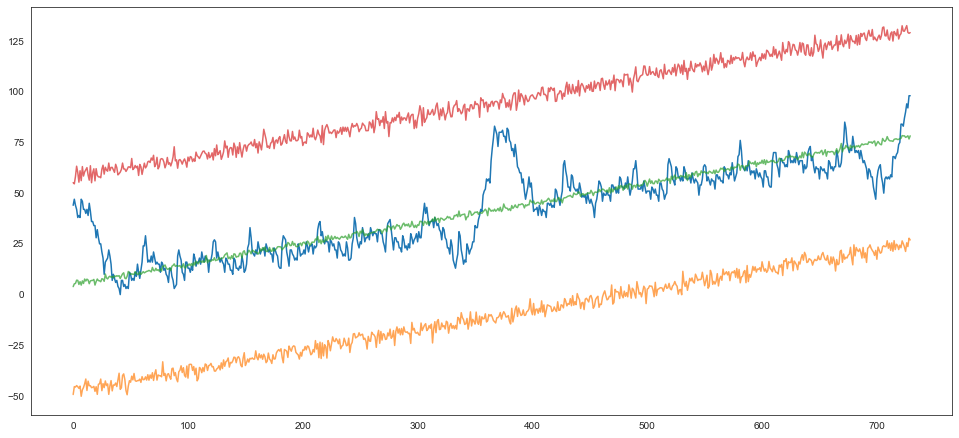

27.86794520547945


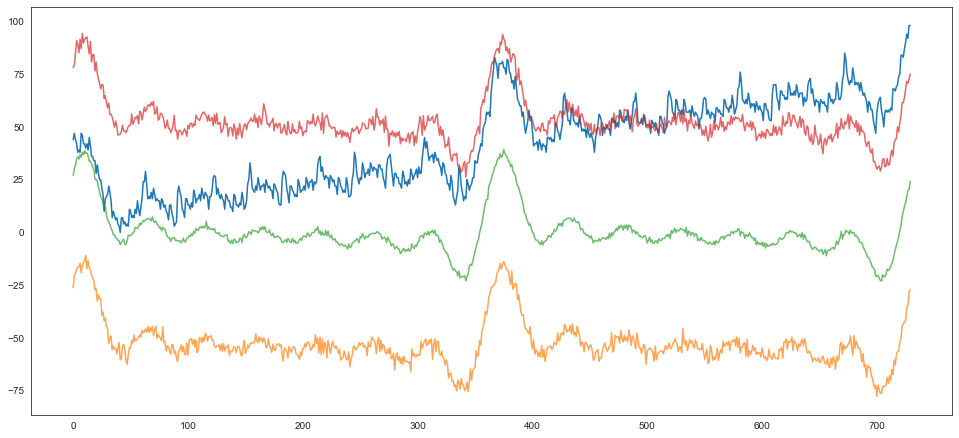

62.757019530899846


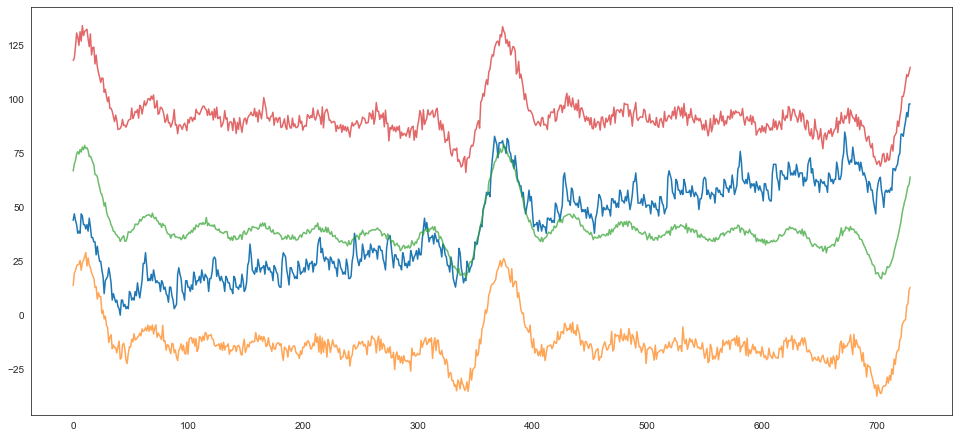

29.854558723395904


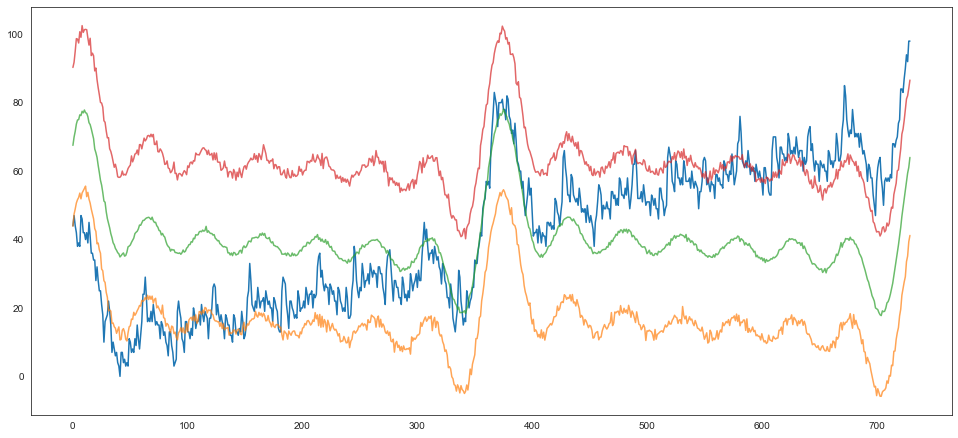

28.836429773709654


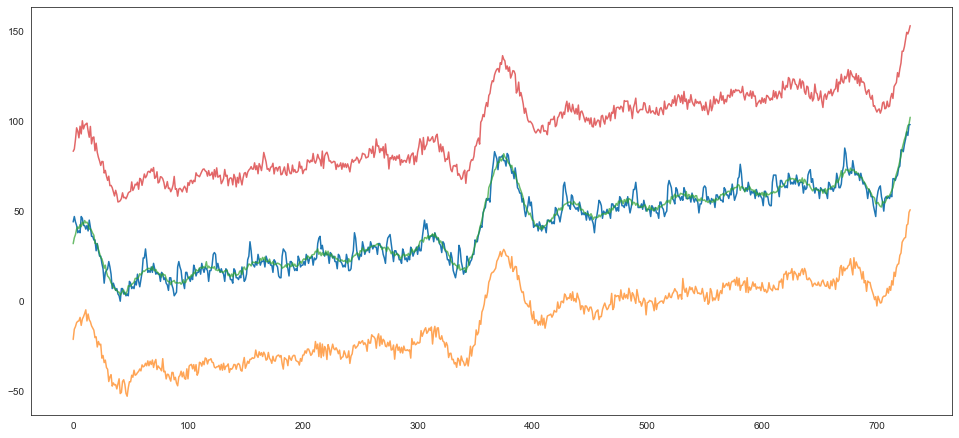

27.0


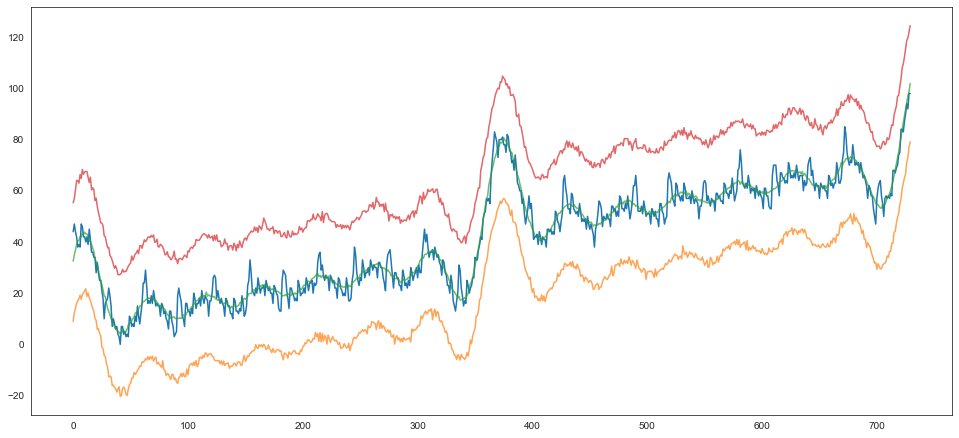

12.018322337621147


In [18]:
mu_mean_repeat = np.repeat(np.mean(mu).round(0).astype(int), t.size)
forecast_means = [mu_mean_repeat, mu_mean_repeat, trend, yearly_seas, yearly_seas+40, yearly_seas+40, trend+yearly_seas, trend+yearly_seas]

forecast_sd_low_repeat = np.repeat(((np.quantile(mu, 0.75) - np.quantile(mu, 0.25))/3).round(0).astype(int), t.size)
forecast_sd_high_repeat = np.repeat(((np.quantile(mu, 0.99) - np.quantile(mu, 0.01))/3).round(0).astype(int), t.size)
forecast_sds = [forecast_sd_high_repeat, forecast_sd_low_repeat, forecast_sd_high_repeat, forecast_sd_high_repeat, forecast_sd_high_repeat, forecast_sd_low_repeat, forecast_sd_high_repeat, forecast_sd_low_repeat]

for mean, sd in zip(forecast_means, forecast_sds):
    forecast_1_samples = get_forecast_samples(mean, sd)
    pred = get_forcast_range(forecast_1_samples)

    plt.figure(figsize=(16.5, 7.5))
    plt.plot(mu)
    plt.plot(pred[:,0], alpha=0.7)
    plt.plot(pred[:,1], alpha=0.7)
    plt.plot(pred[:,2], alpha=0.7)
    plt.show()
    
    train_pred = pd.DataFrame({'t': t, 'onrent': mu, 'onrent_pred_mean': mean, 'onrent_pred_stddev': sd})
    metric = get_error_sd_metric(train_pred.copy(deep=True))
    print(metric)

## Together - get_z_metric

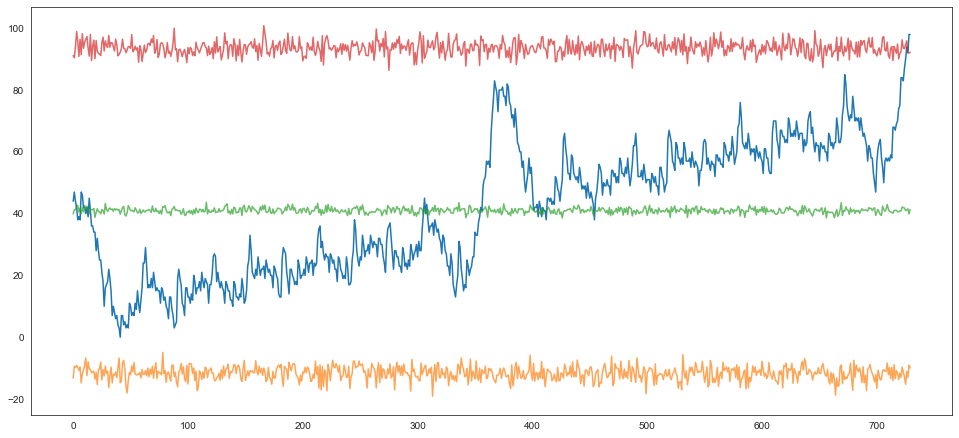

0.11687237984443229


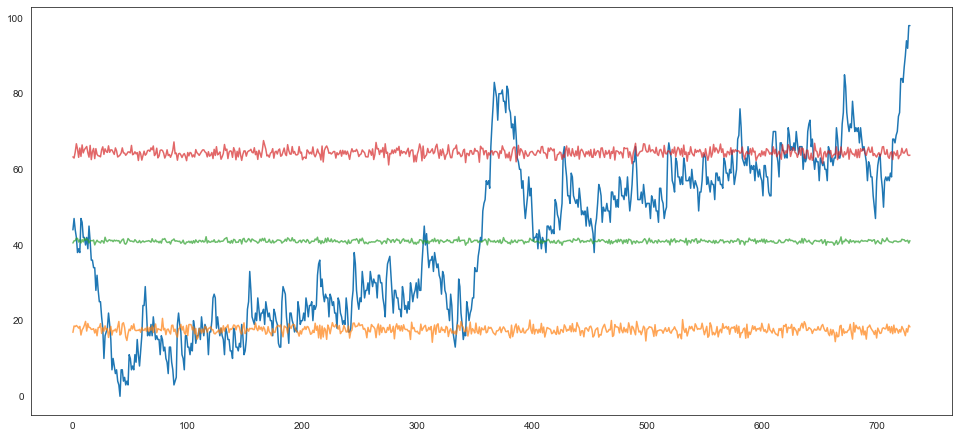

-0.7488683608963085


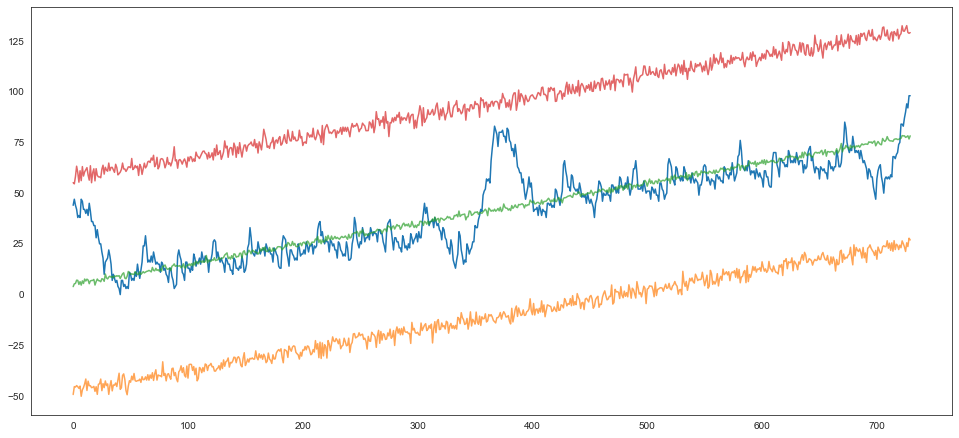

-0.037363332556085684


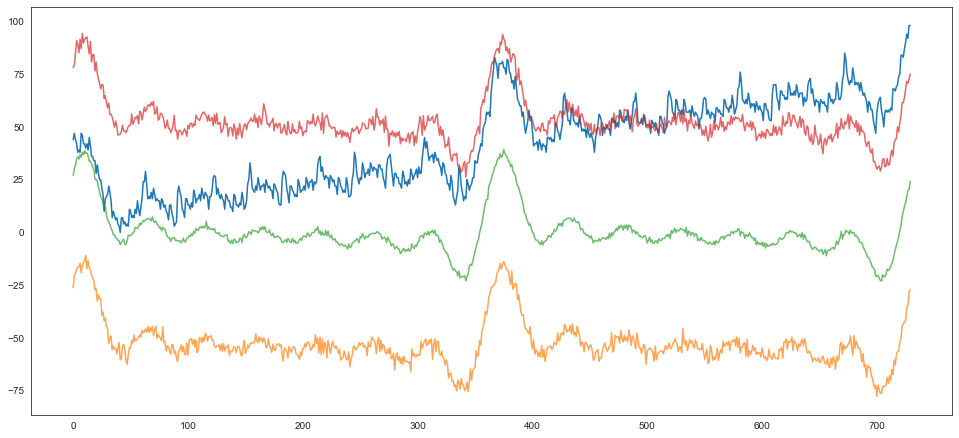

-0.5244334713557208


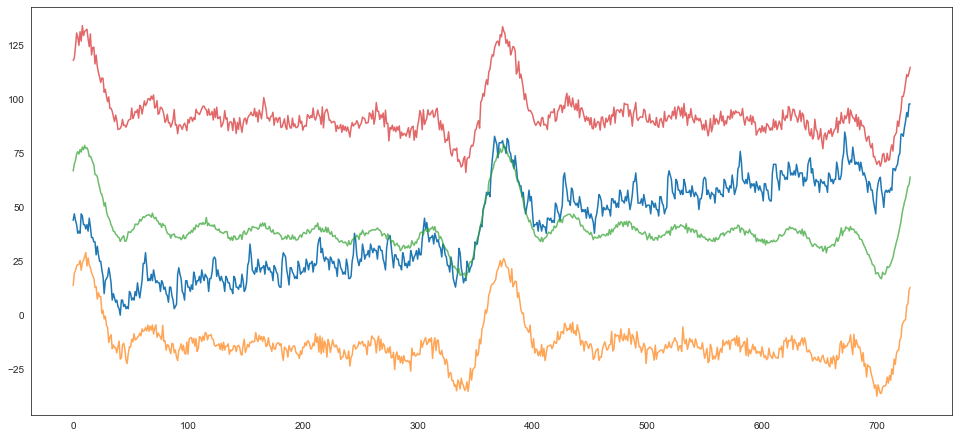

0.06818799098154461


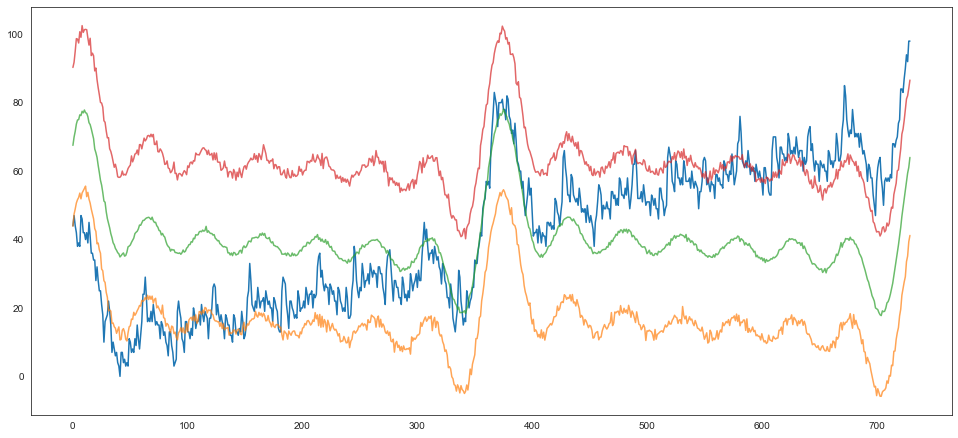

-0.7852585982913023


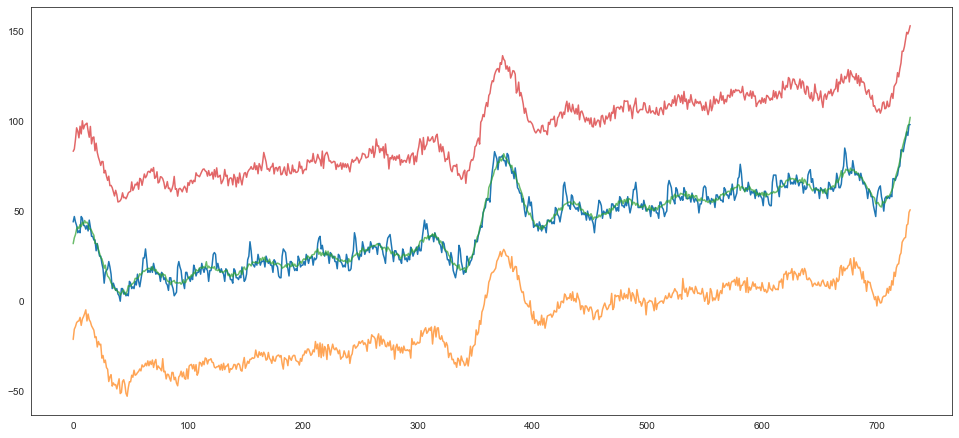

-0.0024621229178558362


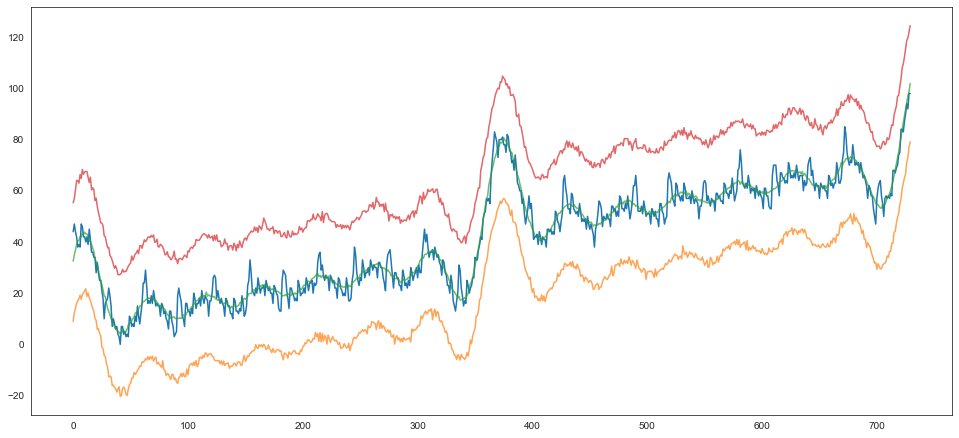

-0.14034737086518892


In [19]:
mu_mean_repeat = np.repeat(np.mean(mu).round(0).astype(int), t.size)
forecast_means = [mu_mean_repeat, mu_mean_repeat, trend, yearly_seas, yearly_seas+40, yearly_seas+40, trend+yearly_seas, trend+yearly_seas]

forecast_sd_low_repeat = np.repeat(((np.quantile(mu, 0.75) - np.quantile(mu, 0.25))/3).round(0).astype(int), t.size)
forecast_sd_high_repeat = np.repeat(((np.quantile(mu, 0.99) - np.quantile(mu, 0.01))/3).round(0).astype(int), t.size)
forecast_sds = [forecast_sd_high_repeat, forecast_sd_low_repeat, forecast_sd_high_repeat, forecast_sd_high_repeat, forecast_sd_high_repeat, forecast_sd_low_repeat, forecast_sd_high_repeat, forecast_sd_low_repeat]

for mean, sd in zip(forecast_means, forecast_sds):
    forecast_1_samples = get_forecast_samples(mean, sd)
    pred = get_forcast_range(forecast_1_samples)

    plt.figure(figsize=(16.5, 7.5))
    plt.plot(mu)
    plt.plot(pred[:,0], alpha=0.7)
    plt.plot(pred[:,1], alpha=0.7)
    plt.plot(pred[:,2], alpha=0.7)
    plt.show()
    
    train_pred = pd.DataFrame({'t': t, 'onrent': mu, 'onrent_pred_mean': mean, 'onrent_pred_stddev': sd})
    metric = get_z_metric(train_pred.copy(deep=True))
    print(metric)